Simple Kalman filter/smoother demo
=========================

In this demo, we'll build a Kalman filter/smoother using the ForneyLab toolbox. The goal is to filter noisy scalar observations.

Let `xin` be the (unknown) state of the system, `xout` the next state, `u` the system input and `y` the noisy observation of `xin`:

\begin{align*}
    x_{out} &= x_{in} + u\\
    y &= x_{in} + n\\
    u &= u_{const}\\
    n &\sim \mathcal{N}(0, V_{noise})\,.
\end{align*}

For simplicity, we assume that `u` is a constant: `u_const`. We further assume that the observations are corrupted by white Gaussian noise, with variance `V_noise`. 

The Kalman filter can be represented as a Forney-style factor graph:

```
                   (u)
            (equ)   |
    (xin) --> = --> + --> (xout)
              |    (add_u_xin)
       (n)--> +(add_n_xin)
              |
             (y)
```

The complete Kalman filter is obtained by chaining multiple of these sections, connecting `xout` of the previous stage to `xin` of the next stage. 

Kalman smoother smooths the predicted values by using message passing in the backward direction.

Let's start by importing ForneyLab, defining the constants and creating the nodes:

In [1]:
using ForneyLab

# Settings
V_noise = 200.0 # variance of the noise (n)
u_const = 1.0   # fixed value for u

# Create nodes
PriorNode(id=:xin)
TerminalNode(id=:xout)
TerminalNode(Gaussian(m=0.0, V=V_noise), id=:n)
TerminalNode(Delta(), id=:y)
AdditionNode(id=:add_n_xin)
EqualityNode(id=:equ)
AdditionNode(id=:add_u_xin)
TerminalNode(Delta(u_const), id=:u);

As you can see, we create terminal and prior nodes for the nodes that hold known values or distributions. We can pass the value of a `TerminalNode` to the constructor, as we do for the `n` and `u` nodes. These nodes will always send out a message with this payload. The `Gaussian` is defined by its mean vector (`m`) and covariance matrix (`V`). The message of the `u` node has zero variance since we have no uncertainty about its value. Further, we have 2 addition nodes and 1 equality constraint node with 3 interfaces.

Now let's connect the nodes by defining the edges, and define a time wrap to connect the sections:

In [2]:
# Create edges
Edge(n(:xin), n(:equ).i[1])
Edge(n(:n), n(:add_n_xin).i[:in1])
Edge(n(:y), n(:add_n_xin).i[:out])
Edge(n(:add_n_xin).i[:in2], n(:equ).i[2])
Edge(n(:equ).i[3], n(:add_u_xin).i[:in2])
Edge(n(:u), n(:add_u_xin).i[:in1])
Edge(n(:add_u_xin).i[:out], n(:xout), id=:marginal)

# Define wrap to chain time sections
Wrap(n(:xout), n(:xin), block_size=100); # Feed posterior estimate to prior

# Inspect the graph
draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8534010306505109648 -->
 8534010306505109648 
 
 xin 
 
<!-- 1153839458575497812 -->
 1153839458575497812 
 
 = 
 equ 
 
<!-- 8534010306505109648->1153839458575497812 -->
 8534010306505109648->1153839458575497812 
 
 
 1 1 
 1 out 
 
<!-- 3978552516037382326 -->
 3978552516037382326 
 
 xout 
 
<!-- 3978552516037382326->8534010306505109648 -->
 3978552516037382326->8534010306505109648 
 
 
 
<!-- 13509533460817601160 -->
 13509533460817601160 
 
 u 
 
<!-- 16023970656852694201 -->
 16023970656852694201 
 
 + 
 add_u_xin 
 
<!-- 13509533460817601160->16023970656852694201 -->
 13509533460817601160->16023970656852694201 
 
 
 1 in1 
 1 out 
 
<!-- 12675949689209514440 -->
 12675949689209514440 
 
 n 
 
<!-- 2713387196689667695 -->
 2713387196689667695 
 
 + 
 add_n_xin 
 
<!-- 12675949689209514440->2713387196689667695 -->
 12675949689209514440->2713387196689667695 
 
 
 1 in1 
 1 out 
 
<!-- 16023970656852694201->3978552516037382326 -->
 16023970656852694201->3978552516037382326 
 
 
 1 out 
 3 out 
 
<!-- 1153839458575497812->16023970656852694201 -->
 1153839458575497812->16023970656852694201 
 
 
 2 in2 
 3 3 
 
<!-- 11540363374273367743 -->
 11540363374273367743 
 
 y 
 
<!-- 11540363374273367743->2713387196689667695 -->
 11540363374273367743->2713387196689667695 
 
 
 3 out 
 1 out 
 
<!-- 2713387196689667695->1153839458575497812 -->
 2713387196689667695->1153839458575497812 
 
 
 2 2 
 2 in2

Now that the factor graph is complete, we can set the initial message, create the message passing schedule, and create a buffer to hold the results. In addition to the write buffer, which was introduced in the previous demo, we also define a read buffer that reads an input value on each call to `step()`.

In [3]:
# Set prior on xin to get started
n(:xin).value = Gaussian(m=0.0, V=1000.0)

# Data
n_samples = 100
noisy_y = [i+randn()*sqrt(V_noise) for i=1:n_samples] # Generate noisy observations of y
attachReadBuffer(n(:y), deepcopy(noisy_y)) # Read buffers consume their argument. We make a copy because we wish to access noisy_y later on.
y = [i for i=1:n_samples] # Non-noisy values

# Create output buffer to record the values we wish to observe in every timestep
state = Vector{ProbabilityDistribution}(100)
attachWriteBuffer(n(:add_u_xin).i[:out], state)

# Declare the inference procedure
algo = SumProduct()

show(algo.schedule)

Message passing schedule
------------------------

1.
SumProductRule on TerminalNode u interface 1 (out)
DataType[Void] -> Message{Delta{Float64}}

2.
SumProductRule on TerminalNode xin interface 1 (out)
DataType[Void] -> Message{Gaussian}

3.
SumProductRule on TerminalNode n interface 1 (out)
DataType[Void] -> Message{Gaussian}

4.
SumProductRule on TerminalNode y interface 1 (out)
DataType[Void] -> Message{Delta{Float64}}

5.
SumProductRule on AdditionNode add_n_xin interface 2 (in2)
DataType[Message{Gaussian},Void,Message{Delta{Float64}}] -> Message{Gaussian}

6.
SumProductRule on EqualityNode equ interface 3 (3)
DataType[Message{Gaussian},Message{Gaussian},Void] -> Message{Gaussian}

7.
SumProductRule on AdditionNode add_u_xin interface 3 (out)
DataType[Message{Delta{Float64}},Message{Gaussian},Void] -> Message{Gaussian}

8.
SumProductRule on TerminalNode xout interface 1 (out)
DataType[Void] -> Message{Gaussian}

9.
SumProductRule on AdditionNode add_u_xin interface 2 (in2)
DataTy

All set. Now we apply the filter by calculating the message towards `xout`. Then, we move this message to `xin` and repeat the process until the read buffer is consumed. This way, we simulate a forward pass over 100 sections.

In [4]:
# Do forward passes
run(algo)

That was easy!
Let's plot the filter output (mean and standard deviation of `xout`) together with the noisy observations to see if it worked.

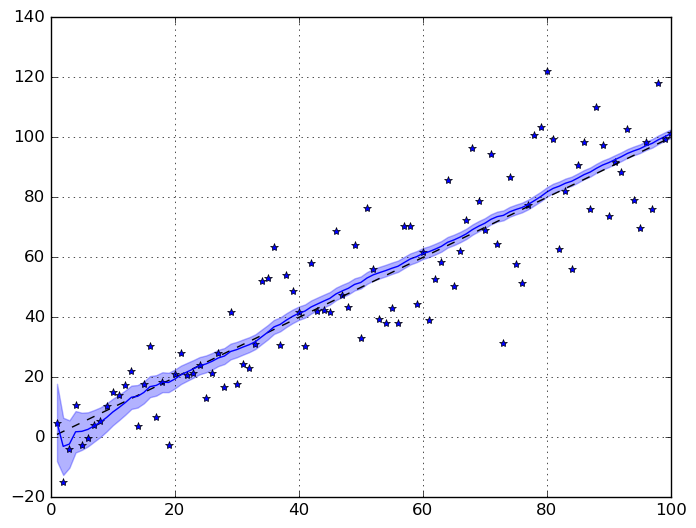

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
using PyPlot
results_mean = Float64[mean(s)[1] for s in state]
results_variance = Float64[var(s)[1,1] for s in state]

plot(collect(1:n_samples), noisy_y, "b*")
plot(collect(1:n_samples), y, "k--")
plot(collect(1:n_samples), results_mean, "b-")
fill_between(collect(1:n_samples), results_mean-sqrt(results_variance), results_mean+sqrt(results_variance), color="b", alpha=0.3);
grid(true)

The wraps also support backward message passing. Let's calculate the marginals on the edge with id `:marginal`, thus implementing Kalman smoother:

In [6]:
marginals = Vector{ProbabilityDistribution}(100)
attachWriteBuffer(edge(:marginal), marginals)

run(algo, direction=:backward)

Let's plot the newly obtained marginals to see if our smoothing was successful.

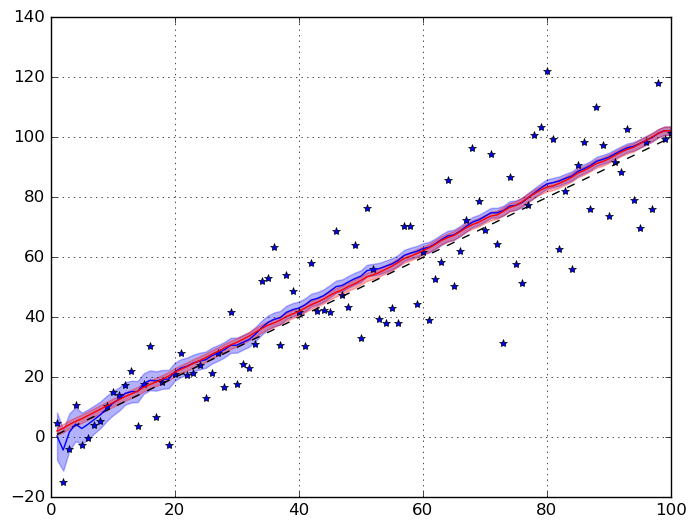

In [7]:
using PyPlot
results_mean = Float64[mean(s)[1] for s in state]
results_variance = Float64[var(s)[1,1] for s in state]
smooth_mean = Float64[mean(s)[1] for s in marginals]
smooth_variance = Float64[var(s)[1,1] for s in marginals]

plot(collect(1:n_samples), noisy_y, "b*")
plot(collect(1:n_samples), y, "k--")
plot(collect(1:n_samples), results_mean, "b-")
plot(collect(1:n_samples), smooth_mean, "r-")
fill_between(collect(1:n_samples), results_mean-sqrt(results_variance), results_mean+sqrt(results_variance), color="b", alpha=0.3);
fill_between(collect(1:n_samples), smooth_mean-sqrt(smooth_variance), smooth_mean+sqrt(smooth_variance), color="r", alpha=0.3);
grid(true)